# Capstone 2 - Final Version - Youtube API and search analysis

In [1]:
import pandas as pd
from tqdm import tqdm
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz, process

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from datetime import datetime
today = datetime.today()

pd.options.display.max_rows = 20

## Youtube (YT) query setup
api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxx'  # tom's API key
from apiclient.discovery import build
youtube = build('youtube', 'v3', developerKey=api_key)
type(youtube)

C:\Users\522147\AppData\Local\Continuum\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


googleapiclient.discovery.Resource

In [2]:
# 8 different python related queries to create YT stats and YT video comment extracts
#
#
#query = ('P1', 'python tutorial') 
#query = ('P2', 'python reading CSV files')
#query = ('P3', 'python pandas dataframes')
#query = ('P4', 'python lists')
#query = ('P5', 'python dictionaries')
#query = ('P6', 'python sort functions')
query = ('P7', 'python for Loops')
#query = ('P8', 'python tuples')

#
# Set output excel file titles for each query
#
comments_file = query[0] + '_comments.xlsx'
stats_file = query[0] + '_stats.xlsx'
# =============================================================================
# Search Query Initialisation
# =============================================================================

query_results = youtube.search().list(
        part = 'snippet',
        q = query[1],
        order = 'relevance',     # You can consider using viewCount
        maxResults = 25,         # given the large number of query results, top 25 is fine for our analysis
        type = 'video',          # Channels might appear in search results
        relevanceLanguage = 'en',
        safeSearch = 'moderate',
        ).execute()

print('Query: ', query,'total video extracts:', len(query_results['items']))
# =============================================================================
# Get Video IDs for the YT search response
# =============================================================================
video_id = []
channel = []
video_title = []
video_desc = []
video_age = []
search_rank = []
x=1
for item in query_results['items']:
    video_id.append(item['id']['videoId'])
    channel.append(item['snippet']['channelTitle'])
    video_title.append(item['snippet']['title'])
    video_desc.append(item['snippet']['description'])
    video_date = datetime.strptime(item['snippet']['publishedAt'],'%Y-%m-%dT%H:%M:%S.%fZ') 
    date_delta = (today - video_date).days
    video_age.append(date_delta//7)
    search_rank.append(x)
    x += 1
print('Query: ', query,'total video stats:', len(video_id))

# =============================================================================
# Populate to Dataframe
# =============================================================================

output_dict = {
        'Query Num': query[0],
        'Query': query[1],
        'Search Rank': search_rank,
        'Channel': channel,
        'Video ID': video_id,
        'Video Title': video_title,
        'Video Description': video_desc,
        'Video Age': video_age
        }

# output_df - this will be merged with the results from the stats query
# YT requires 2 separate queries - one for video ids, one for stats
#
output_df = pd.DataFrame(output_dict, columns = output_dict.keys())

# =============================================================================
# Get Video stats
# =============================================================================
#
# Combine video ids into 1 long string to make one block call to YT stats versus individual calls for each video
#
for i in range(0,len(video_id),50):
        video_id_request = ','.join(video_id[i:i+50])

#
# request stats for all video ids
#
res_stats = youtube.videos().list(id=video_id_request, part='statistics').execute()

# =============================================================================
# parse through res_stats for video stats
# =============================================================================
video_id_stats = []
viewCount = []
likeCount = []
dislikeCount = []
commentCount = []
for item in res_stats['items']:
    #video_id_stats.append(item['id'])
    #viewCount.append(item['statistics']['viewCount'])
    #likeCount.append(item['statistics']['likeCount'])
    #dislikeCount.append(item['statistics']['dislikeCount'])
    #commentCount.append(item['statistics']['commentCount'])
    
    if len(item['statistics']) == 5:
        video_id_stats.append(item['id'])
        viewCount.append(item['statistics']['viewCount'])
        likeCount.append(item['statistics']['likeCount'])
        dislikeCount.append(item['statistics']['dislikeCount'])
        commentCount.append(item['statistics']['commentCount'])
    else:
        video_id_stats.append(item['id'])
        viewCount.append(item['statistics']['viewCount'])
        likeCount.append(0)
        dislikeCount.append(0)
        commentCount.append(0)
#
# Output video stats to a dataframe
#
output_dict_stats = {
        'Video ID': video_id_stats,
        'view count': viewCount,
        'like count': likeCount,
        'dislike count': dislikeCount,
        'comment count': commentCount
        }

output_df_stats = pd.DataFrame(output_dict_stats, columns = output_dict_stats.keys())

# Merge video info and video stats into 1 dataframe and output to excel
output_df_stats = output_df.merge(output_df_stats, left_on='Video ID', right_on='Video ID', how = 'left')
output_df_stats.to_excel(stats_file)
print('Completed output file:', stats_file)


Query:  ('P7', 'python for Loops') total video extracts: 25
Query:  ('P7', 'python for Loops') total video stats: 25
Completed output file: P7_stats.xlsx


In [3]:
#
# Separate queries to get the most relevant 100 queries for each video
#
# =============================================================================
# Get Comments of Top Videos
# =============================================================================
video_id_pop = []
channel_pop = []
video_num_pop = []
video_title_pop = []
video_desc_pop = []
comments_pop = []
comment_id_pop = []
reply_count_pop = []
like_count_pop = []

for i, video in enumerate(tqdm(video_id, ncols = 100)):
    response = youtube.commentThreads().list(
                    part = 'snippet',
                    videoId = video,
                    maxResults = 100, # Only take top 100 comments...
                    order = 'relevance', #... ranked on relevance
                    textFormat = 'plainText',
                    ).execute()
    
    comments_temp = []
    comment_id_temp = []
    reply_count_temp = []
    like_count_temp = []
    for item in response['items']:
        comments_temp.append(item['snippet']['topLevelComment']['snippet']['textDisplay'])
        comment_id_temp.append(item['snippet']['topLevelComment']['id'])
        reply_count_temp.append(item['snippet']['totalReplyCount'])
        like_count_temp.append(item['snippet']['topLevelComment']['snippet']['likeCount'])
        video_num_pop.append(str(i+1))
    comments_pop.extend(comments_temp)
    comment_id_pop.extend(comment_id_temp)
    reply_count_pop.extend(reply_count_temp)
    like_count_pop.extend(like_count_temp)
    
    video_id_pop.extend([video_id[i]]*len(comments_temp))
    channel_pop.extend([channel[i]]*len(comments_temp))
    video_title_pop.extend([video_title[i]]*len(comments_temp))
    video_desc_pop.extend([video_desc[i]]*len(comments_temp))
    
# =============================================================================
# Populate to Dataframe
# =============================================================================
output_dict_comments = {
        'Query Num': query[0], #_pop_id,
        'Query': query[1],
        'Channel': channel_pop,
        'Video Num': video_num_pop,
        'Video ID': video_id_pop,
        'Video Title': video_title_pop,
        'Video Description': video_desc_pop,
        'Comment': comments_pop,
        'Comment ID': comment_id_pop,
        'Replies': reply_count_pop,
        'Likes': like_count_pop,
        }

output_df_comments = pd.DataFrame(output_dict_comments, columns = output_dict_comments.keys())
# output comments to excel
output_df_comments.to_excel(comments_file)
print('Completed output file:', comments_file)


100%|███████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.15it/s]


Completed output file: P7_comments.xlsx


# Capstone 2 - EDA

In [4]:
# 8 separate python query results with the YT query stats
p1 = pd.read_excel('P1_stats.xlsx')
p2 = pd.read_excel('P2_stats.xlsx')
p3 = pd.read_excel('P3_stats.xlsx')
p4 = pd.read_excel('P4_stats.xlsx')
p5 = pd.read_excel('P5_stats.xlsx')
p6 = pd.read_excel('P6_stats.xlsx')
p7 = pd.read_excel('P7_stats.xlsx')
p8 = pd.read_excel('P8_stats.xlsx')

p1query = p1['Query Num'][0] + " " + p1['Query'][0]
p2query = p2['Query Num'][0] + " " + p2['Query'][0]
p3query = p3['Query Num'][0] + " " + p3['Query'][0]
p4query = p4['Query Num'][0] + " " + p4['Query'][0]
p5query = p5['Query Num'][0] + " " + p5['Query'][0]
p6query = p6['Query Num'][0] + " " + p6['Query'][0]
p7query = p7['Query Num'][0] + " " + p7['Query'][0]
p8query = p8['Query Num'][0] + " " + p8['Query'][0]

p1out = 'p1_stats.png'
p2out = 'p2_stats.png'
p3out = 'p3_stats.png'
p4out = 'p4_stats.png'
p5out = 'p5_stats.png'
p6out = 'p6_stats.png'
p7out = 'p7_stats.png'
p8out = 'p8_stats.png'

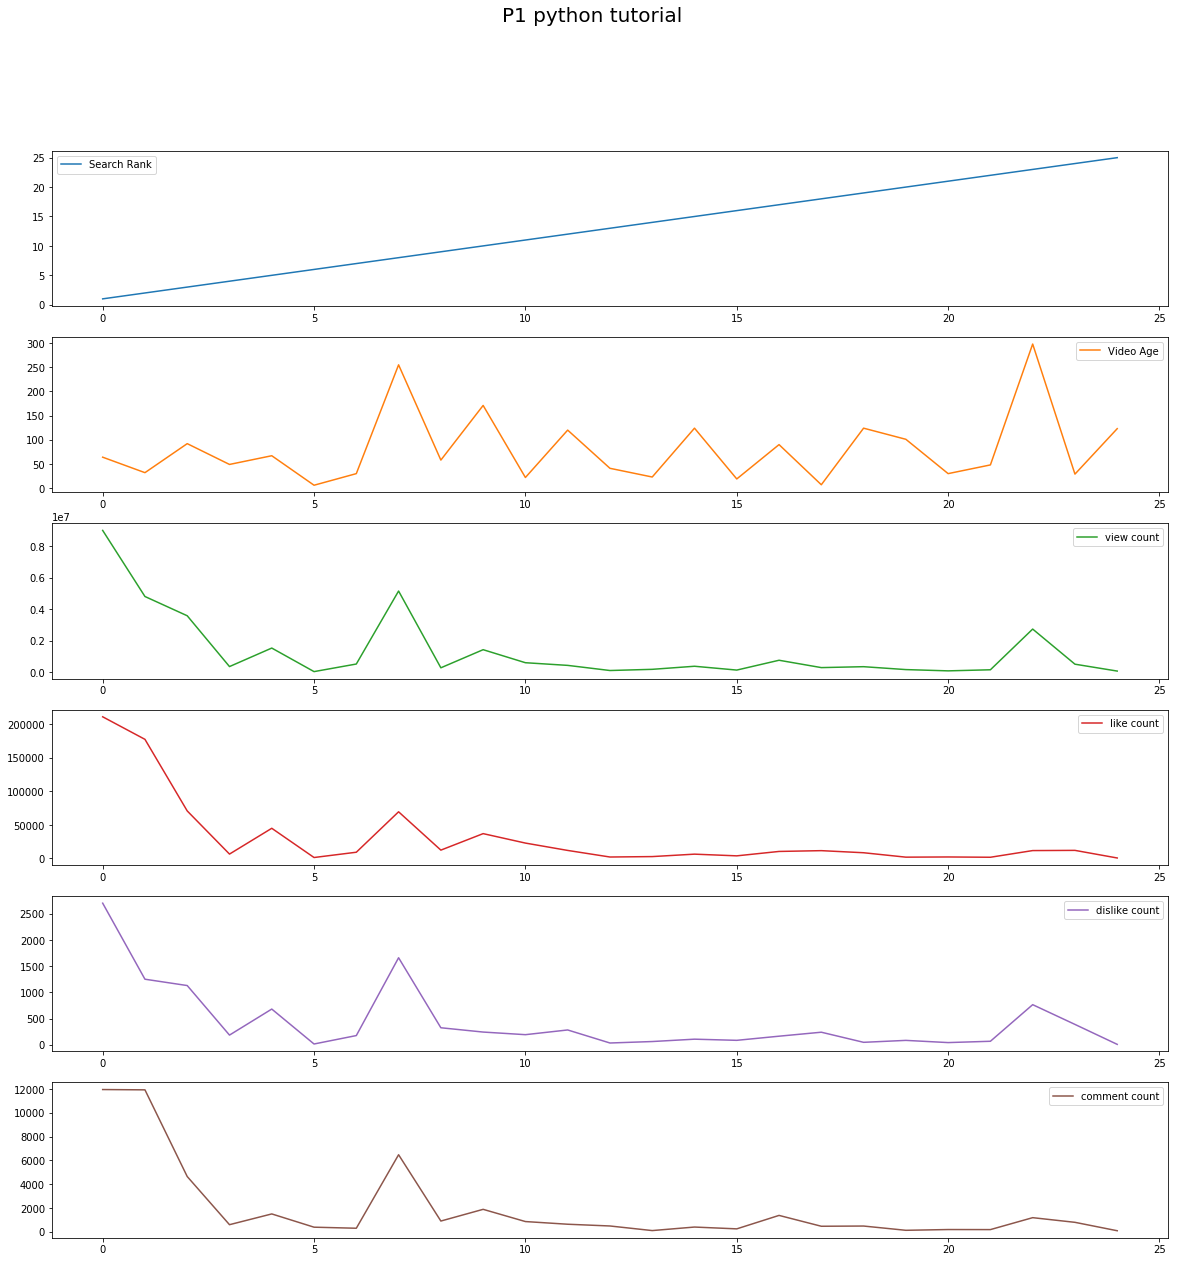

In [5]:
# PLots of each python query YT stats
p1.plot(subplots = True, figsize = (20,20), sharex = False)
plt.suptitle(p1query, fontsize = 20)
plt.savefig(p1out, dpi=300)
plt.show()

# Capstone 2 - Naive Bayes Prediction

In [6]:
#from glob import glob
comments_files = sorted(glob(r"C:\Users\522147\Documents\1 Python\1Springboard Data Science\1Capstone 2\*comments_tag*.xl*"))

comments_files

['C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P1_comments_tagged.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P2_comments_tagged.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P3_comments_tagged.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P4_comments_tagged.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P5_comments_tagged.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P6_comments_tagged.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P7_comments_tagged.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P8_comments_tagged.xlsx']

In [7]:
df_all_comments = pd.concat((pd.read_excel(file) for file in comments_files), ignore_index=True)

In [8]:
print(df_all_comments.shape)
print(df_all_comments.columns)

(8492, 12)
Index(['Query Num', 'Query', 'Channel', 'Video Num', 'Video ID', 'Video Title',
       'Video Description', 'Comment', 'Comment ID', 'Replies', 'Likes',
       'Very_Pos'],
      dtype='object')


In [9]:
df_all_comments.Very_Pos.value_counts(dropna=False)

NaN     7372
 1.0     635
 0.0     485
Name: Very_Pos, dtype: int64

In [10]:
df_all_comments.isnull().sum()

Query Num               0
Query                   0
Channel                 0
Video Num               0
Video ID                0
Video Title             0
Video Description       3
Comment                 2
Comment ID              0
Replies                 0
Likes                   0
Very_Pos             7372
dtype: int64

In [11]:
df_all_comments_tagged = df_all_comments[df_all_comments.Very_Pos.notnull()]

In [12]:
df_all_comments_tagged.shape

(1120, 12)

In [13]:
df_all_comments_not_tagged = df_all_comments[df_all_comments.Very_Pos.isnull()]

In [14]:
df_all_comments_not_tagged.shape

(7372, 12)

In [15]:
# Define X (comment) and y (Pos Comment = 1, others = 0)
X = df_all_comments_tagged.Comment
y = df_all_comments_tagged.Very_Pos

In [16]:
X.head()

1    *[ Comment Deleted ]*\n\n\n\n*You’ll never how...
3    One minute in : Assigning a = 5\n4 hours in : ...
5    0:00 introduction\r\n1:45 installing python an...
7    Funny that it counts characters in the string ...
9    /oo ? Agency =[AISA,NASA]\nFor i in Agency:\nP...
Name: Comment, dtype: object

In [17]:
y.head()

1    0.0
3    0.0
5    0.0
7    0.0
9    0.0
Name: Very_Pos, dtype: float64

In [18]:
y.value_counts()

1.0    635
0.0    485
Name: Very_Pos, dtype: int64

In [19]:
# split X and y into training and testing sets
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(840,)
(280,)
(840,)
(280,)


In [20]:
# Instantiate CountVectorizer
vect = CountVectorizer()

In [21]:
# fit and transform X_train into X_train_dtm
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm.shape

(840, 2665)

In [22]:
# transform X_test into X_test_dtm
X_test_dtm = vect.transform(X_test)
X_test_dtm.shape

(280, 2665)

In [23]:
# Use Navie Bayes for prediction
nb = MultinomialNB()

In [24]:
# train the model using X_train_dtm
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [26]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred_class)

0.7821428571428571

In [27]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[ 62,  59],
       [  2, 157]], dtype=int64)

In [28]:
# Predict null accuracy 
y_test.value_counts()

1.0    159
0.0    121
Name: Very_Pos, dtype: int64

In [29]:
# calculate null accuracy
y_test.value_counts().head() / y_test.shape  # just guessing positive is 56% correct

1.0    0.567857
0.0    0.432143
Name: Very_Pos, dtype: float64

## Calculate the top 10 tokens for positive comments

In [30]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

2665

In [31]:
# first row is positive YT comments, second row is other types of comments 
nb.feature_count_.shape

(2, 2665)

In [32]:
nb.feature_count_

array([[38.,  4.,  1., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [33]:
# store the number of times each token appears across each class
pos_token_count = nb.feature_count_[1, :]
notpos_token_count = nb.feature_count_[0, :]

In [34]:
# create a DataFrame of tokens with their separate one-star and five-star counts
tokens = pd.DataFrame({'token':X_train_tokens, 'positive':pos_token_count, 'other':notpos_token_count}).set_index('token')

In [35]:
# add 1 to positive and other type comments to avoid dividing by 0
tokens['positive'] = tokens.positive + 1
tokens['other'] = tokens.other + 1

In [36]:
# calculate the ratio of positive to other type comments for each token
tokens['positive_ratio'] = tokens.positive / tokens.other

In [37]:
# sort the DataFrame by the positive ratio (descending order)
tokens.sort_values('positive_ratio', ascending=False).head(20)

,positive,other,positive_ratio
token,,,
excellent,22.0,1.0,22.000000
awesome,35.0,2.0,17.500000
watched,16.0,1.0,16.000000
thank,156.0,10.0,15.600000
much,77.0,5.0,15.400000
amazing,29.0,2.0,14.500000
simple,14.0,1.0,14.000000
best,54.0,4.0,13.500000
very,79.0,6.0,13.166667


In [38]:
# first 10 false positives (meaning they were incorrectly as positive comments)
X_test[y_test < y_pred_class][0:10]

109     as of today I am learning Python for my Job[Un...
609     Plz make a video on Android development throug...
2750    Hey man, I know it's an old video but I was wo...
821     2:05 " its really like a book" yes but I prefe...
205     Please make the whole series of python 👍and al...
823     why it seems to me that he was almost laughing...
729     What's the name of this beautiful font? :D And...
3041    what is the purpose of that newline parameter ...
1885    PyCharm is far better than microsoft visual st...
1333                                 what is this editor?
Name: Comment, dtype: object

In [39]:
# first 10 false negatives (meaning they were incorrectly classified other comments)
X_test[y_test > y_pred_class][0:10]

2321    Hey Kevin, Great videos! I have a question reg...
739     Hello Derek,\n\nthank you very much for the wo...
Name: Comment, dtype: object

# Testing Different Approaches to improve accuracy

In [40]:
# show default parameters for CountVectorizer
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [41]:
# define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test(vect):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Multinomial Naive Bayes to predict the star rating
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    
    # print the accuracy of its predictions
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

In [42]:
# use the default parameters
vect = CountVectorizer()
tokenize_test(vect)

Features:  2665
Accuracy:  0.7821428571428571


In [43]:
# don't convert to lowercase
vect = CountVectorizer(lowercase=False)
tokenize_test(vect)

Features:  3175
Accuracy:  0.7428571428571429


In [44]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))
tokenize_test(vect)

Features:  14031
Accuracy:  0.775


In [45]:
# remove English stop words
vect = CountVectorizer(stop_words='english')
tokenize_test(vect)

Features:  2440
Accuracy:  0.7785714285714286


In [46]:
# ignore terms that appear in more than 50% of the documents
# 1.0 means allow all terms
vect = CountVectorizer(max_df=0.5)
tokenize_test(vect)

Features:  2665
Accuracy:  0.7821428571428571


In [47]:
# adjust for min_df = 2
vect = CountVectorizer(min_df=2)
tokenize_test(vect)

Features:  1213
Accuracy:  0.8107142857142857


In [48]:
# include 1-grams and 2-grams, and only keep terms that appear in at least 2 documents
# here we are combining options - we thought ngram_range was useful but by itself, it added more noise
vect = CountVectorizer(ngram_range=(1, 2), min_df=3)
tokenize_test(vect)

Features:  1500
Accuracy:  0.8285714285714286


In [49]:
# this is the highest accuracy - use this
# fit and transform X into X_dtm
X_dtm = vect.fit_transform(X)
X_dtm.shape

(1120, 1948)

# Predicting for the other comments

In [50]:
df_all_comments_not_tagged_comments = df_all_comments_not_tagged.Comment

In [51]:
print(type(df_all_comments_not_tagged_comments))

<class 'pandas.core.series.Series'>


In [52]:
df_all_comments_not_tagged_comments.isnull().sum()

2

In [53]:
df_all_comments_not_tagged_comments.fillna("none", inplace=True)

C:\Users\522147\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [54]:
df_all_comments_not_tagged_comments.isnull().sum()

0

In [55]:
# transform new_comments new_dtm
new_dtm = vect.transform(df_all_comments_not_tagged_comments)
new_dtm.shape

(7372, 1948)

In [56]:
new_dtm

<7372x1948 sparse matrix of type '<class 'numpy.int64'>'
	with 122110 stored elements in Compressed Sparse Row format>

In [57]:
new_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [58]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(new_dtm.toarray(), columns=vect.get_feature_names())

,00,00 00,00 introduction,000,01,03,04,05,06,07,...,your tutorials,your video,your videos,yours,yours is,yourself,youtube,youtube and,youtube channels,youtubers
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
print(X_dtm.shape)
print(y.shape)

(1120, 1948)
(1120,)


In [60]:
# train a MultinomialNB model
nb = MultinomialNB()
nb.fit(X_dtm, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [61]:
# calculate the predicted probability of "rude service" for each new comment
new_pred_prob = nb.predict_proba(new_dtm)[:, 1]

In [62]:
# widen the column display
pd.set_option('display.max_colwidth', 1000)

In [63]:
# print the comment text alongside the predicted "rude probability"
# note: use sort() instead of sort_values() prior to pandas 0.17
#df_all_comments_predicted = pd.DataFrame({'comment':df_all_comments_not_tagged_comments, 'pos_prob':new_pred_prob}).sort_values('pos_prob', ascending=False)
df_all_comments_predicted = pd.DataFrame({'comment':df_all_comments_not_tagged_comments, 'pos_prob':new_pred_prob})
df_all_comments_predicted

,comment,pos_prob
0,Hey everyone! Thanks for watching my course\n\nFollow me on twitter at https://twitter.com/mike_dane,0.997398
2,2400 dislikes are people that offer paid courses for programming.,0.990465
4,print('friends')\n\nconsole: Error. You have no friends,0.025401
6,"I retired this last year after having been a professional programmer for 39 years. Started with Fortran and COBOL and lots of little proprietary systems that probably no longer exist. I spent the last few years with Groovy, PERL, Python, Java, SQLServer, Amazon cloud programming and a bunch of other systems. I loved Python, and decided to just go back to basics and find a good Python refresher course. Although I already know the stuff in this tutorial, I want to compliment Mike Dane on his presentation and content. This is a really worthwhile intro course. He does a very good job. I thoroughly enjoyed revisiting this material!!!,",1.000000
8,print(“hello world”),0.000081
10,"Haha, i have a python exam tomorrow, im only 45 mins into this video and ive already learned more than i have all year in class. \n1 like = 1 prayer for me to pass my exam",0.992327
12,"Im 50 and dont know anything about programing , but this is what I need to learn to built and run my backyard greenhouse.\nNever too old to learn new things.",0.225303
14,"Don't mind me, just setting my timestamp: 8:30",0.152743
16,"Colleges after this course\n""I declare BANKRUPTCY!!""",0.827396
18,"Thank you so much for creating this course, I'm teaching myself python as I'll be able to use it in my cryptography class to do arithmetic in solving ciphers. You truly have a future as an educator, and I'm astounded that you're not charging people for the volumes of information you offer. Thank you so much for everything you do.",1.000000


In [64]:
df_all_comments_predicted.to_excel('comments_predicted.xlsx')

In [65]:
df_all_comments_predicted.columns

Index(['comment', 'pos_prob'], dtype='object')

In [66]:
df_all_comments_not_tagged_comments.shape

(7372,)

In [67]:
df_all_comments_not_tagged_comments.reset_index()

,index,Comment
0,0,Hey everyone! Thanks for watching my course\n\nFollow me on twitter at https://twitter.com/mike_dane
1,2,2400 dislikes are people that offer paid courses for programming.
2,4,print('friends')\n\nconsole: Error. You have no friends
3,6,"I retired this last year after having been a professional programmer for 39 years. Started with Fortran and COBOL and lots of little proprietary systems that probably no longer exist. I spent the last few years with Groovy, PERL, Python, Java, SQLServer, Amazon cloud programming and a bunch of other systems. I loved Python, and decided to just go back to basics and find a good Python refresher course. Although I already know the stuff in this tutorial, I want to compliment Mike Dane on his presentation and content. This is a really worthwhile intro course. He does a very good job. I thoroughly enjoyed revisiting this material!!!,"
4,8,print(“hello world”)
5,10,"Haha, i have a python exam tomorrow, im only 45 mins into this video and ive already learned more than i have all year in class. \n1 like = 1 prayer for me to pass my exam"
6,12,"Im 50 and dont know anything about programing , but this is what I need to learn to built and run my backyard greenhouse.\nNever too old to learn new things."
7,14,"Don't mind me, just setting my timestamp: 8:30"
8,16,"Colleges after this course\n""I declare BANKRUPTCY!!"""
9,18,"Thank you so much for creating this course, I'm teaching myself python as I'll be able to use it in my cryptography class to do arithmetic in solving ciphers. You truly have a future as an educator, and I'm astounded that you're not charging people for the volumes of information you offer. Thank you so much for everything you do."


In [68]:
df_all_comments_not_tagged.describe()

,Video Num,Replies,Likes,Very_Pos
count,7372.000000,7372.000000,7372.00000,0.0
mean,10.106348,0.820944,8.94140,NaN
std,7.132966,8.087566,111.19521,NaN
min,1.000000,0.000000,0.00000,NaN
25%,3.000000,0.000000,0.00000,NaN
50%,9.000000,0.000000,0.00000,NaN
75%,16.000000,1.000000,1.00000,NaN
max,25.000000,500.000000,4940.00000,NaN


In [69]:
df_all_comments_predicted.columns

Index(['comment', 'pos_prob'], dtype='object')

In [70]:
df_all_comments_predicted.describe()

,pos_prob
count,7372.000000
mean,0.633314
std,0.429115
min,0.000000
25%,0.081979
50%,0.938977
75%,0.999956
max,1.000000


In [71]:
# merge predicted comments
df_merged_predictions = pd.concat([df_all_comments_not_tagged, df_all_comments_predicted],axis=1)

In [72]:
bins = [0.0 , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
s = pd.cut(df_merged_predictions['pos_prob'], bins = bins).value_counts()
print(s)

(0.9, 1.0]    3851
(0.0, 0.1]    1924
(0.8, 0.9]     305
(0.5, 0.6]     293
(0.1, 0.2]     252
(0.2, 0.3]     188
(0.7, 0.8]     166
(0.3, 0.4]     136
(0.6, 0.7]     129
(0.4, 0.5]     126
Name: pos_prob, dtype: int64


In [73]:
df_merged_predictions.Very_Pos = np.where(df_merged_predictions.pos_prob >= .80, 1, 0)

In [74]:
df_merged_predictions.describe()

,Video Num,Replies,Likes,Very_Pos,pos_prob
count,7372.000000,7372.000000,7372.00000,7372.000000,7372.000000
mean,10.106348,0.820944,8.94140,0.563755,0.633314
std,7.132966,8.087566,111.19521,0.495952,0.429115
min,1.000000,0.000000,0.00000,0.000000,0.000000
25%,3.000000,0.000000,0.00000,0.000000,0.081979
50%,9.000000,0.000000,0.00000,1.000000,0.938977
75%,16.000000,1.000000,1.00000,1.000000,0.999956
max,25.000000,500.000000,4940.00000,1.000000,1.000000


In [75]:
df_merged_predictions.Very_Pos.value_counts()

1    4156
0    3216
Name: Very_Pos, dtype: int64

In [76]:
df_merged_predictions_final = df_merged_predictions.iloc[:].copy()  

In [77]:
df_merged_predictions_final.describe()

,Video Num,Replies,Likes,Very_Pos,pos_prob
count,7372.000000,7372.000000,7372.00000,7372.000000,7372.000000
mean,10.106348,0.820944,8.94140,0.563755,0.633314
std,7.132966,8.087566,111.19521,0.495952,0.429115
min,1.000000,0.000000,0.00000,0.000000,0.000000
25%,3.000000,0.000000,0.00000,0.000000,0.081979
50%,9.000000,0.000000,0.00000,1.000000,0.938977
75%,16.000000,1.000000,1.00000,1.000000,0.999956
max,25.000000,500.000000,4940.00000,1.000000,1.000000


In [78]:
df_merged_predictions_final.drop(['pos_prob','comment'],axis=1)

,Query Num,Query,Channel,Video Num,Video ID,Video Title,Video Description,Comment,Comment ID,Replies,Likes,Very_Pos
0,P1,python tutorial,freeCodeCamp.org,1,rfscVS0vtbw,Learn Python - Full Course for Beginners [Tutorial],This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,Hey everyone! Thanks for watching my course\n\nFollow me on twitter at https://twitter.com/mike_dane,UgxKkKnuUmUIwklRyJ14AaABAg,276,4940,1
2,P1,python tutorial,freeCodeCamp.org,1,rfscVS0vtbw,Learn Python - Full Course for Beginners [Tutorial],This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,2400 dislikes are people that offer paid courses for programming.,Ugyz2bKLxp2L1nys1954AaABAg,14,741,1
4,P1,python tutorial,freeCodeCamp.org,1,rfscVS0vtbw,Learn Python - Full Course for Beginners [Tutorial],This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,print('friends')\n\nconsole: Error. You have no friends,UgyvKRt_NRpsEHe4ZIJ4AaABAg,4,222,0
6,P1,python tutorial,freeCodeCamp.org,1,rfscVS0vtbw,Learn Python - Full Course for Beginners [Tutorial],This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,"I retired this last year after having been a professional programmer for 39 years. Started with Fortran and COBOL and lots of little proprietary systems that probably no longer exist. I spent the last few years with Groovy, PERL, Python, Java, SQLServer, Amazon cloud programming and a bunch of other systems. I loved Python, and decided to just go back to basics and find a good Python refresher course. Although I already know the stuff in this tutorial, I want to compliment Mike Dane on his presentation and content. This is a really worthwhile intro course. He does a very good job. I thoroughly enjoyed revisiting this material!!!,",UgwYxzxJgpB78xhnezd4AaABAg,10,513,1
8,P1,python tutorial,freeCodeCamp.org,1,rfscVS0vtbw,Learn Python - Full Course for Beginners [Tutorial],This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,print(“hello world”),UgwlEPc-_g6ceMbq05d4AaABAg,2,3,0
10,P1,python tutorial,freeCodeCamp.org,1,rfscVS0vtbw,Learn Python - Full Course for Beginners [Tutorial],This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,"Haha, i have a python exam tomorrow, im only 45 mins into this video and ive already learned more than i have all year in class. \n1 like = 1 prayer for me to pass my exam",Ugw2wn1txBA79_QkIrR4AaABAg,116,2333,1
12,P1,python tutorial,freeCodeCamp.org,1,rfscVS0vtbw,Learn Python - Full Course for Beginners [Tutorial],This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,"Im 50 and dont know anything about programing , but this is what I need to learn to built and run my backyard greenhouse.\nNever too old to learn new things.",Ugxx7Y07Z1nSlKTVxFF4AaABAg,7,83,0
14,P1,python tutorial,freeCodeCamp.org,1,rfscVS0vtbw,Learn Python - Full Course for Beginners [Tutorial],This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,"Don't mind me, just setting my timestamp: 8:30",Ugx6HymZ0640r9FDZn94AaABAg,0,1,0
16,P1,python tutorial,freeCodeCamp.org,1,rfscVS0vtbw,Learn Python - Full Course for Beginners [Tutorial],This course will give you a full introduction into all of the core concepts in python. Follow alon

In [79]:
frames = [df_merged_predictions_final,df_all_comments_tagged]
result = pd.concat(frames,sort=False)

In [82]:
result.columns

Index(['Query Num', 'Query', 'Channel', 'Video Num', 'Video ID', 'Video Title',
       'Video Description', 'Comment', 'Comment ID', 'Replies', 'Likes',
       'Very_Pos', 'comment', 'pos_prob'],
      dtype='object')

In [83]:
result.describe()

,Video Num,Replies,Likes,Very_Pos,pos_prob
count,8492.000000,8492.000000,8492.000000,8492.000000,7372.000000
mean,10.232454,1.012365,13.860457,0.564178,0.633314
std,7.184933,9.189071,161.436727,0.495893,0.429115
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.081979
50%,9.000000,0.000000,0.000000,1.000000,0.938977
75%,16.000000,1.000000,1.000000,1.000000,0.999956
max,25.000000,500.000000,7129.000000,1.000000,1.000000


In [84]:
result.Very_Pos.value_counts()

1.0    4791
0.0    3701
Name: Very_Pos, dtype: int64

In [85]:
z = result.groupby('Video ID').sum().sort_values('Very_Pos',ascending=False)

In [86]:
z.columns

Index(['Video Num', 'Replies', 'Likes', 'Very_Pos', 'pos_prob'], dtype='object')

In [87]:
z.to_excel('results.xlsx', columns = ['Very_Pos'])

# Fuzzy Matching 

In [88]:
stats_files = sorted(glob(r"C:\Users\522147\Documents\1 Python\1Springboard Data Science\1Capstone 2\*stats.xl*"))
stats_files

['C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P1_stats.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P2_stats.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P3_stats.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P4_stats.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P5_stats.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P6_stats.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P7_stats.xlsx',
 'C:\\Users\\522147\\Documents\\1 Python\\1Springboard Data Science\\1Capstone 2\\P8_stats.xlsx']

In [89]:
df_all_stats = pd.concat((pd.read_excel(file) for file in stats_files), ignore_index=True)

In [90]:
df_all_stats.rename(columns={"Video Title": "Video_Title"},inplace = True)

In [91]:
df_all_stats

,Query Num,Query,Search Rank,Channel,Video ID,Video_Title,Video Description,Video Age,view count,like count,dislike count,comment count
0,P1,python tutorial,1,freeCodeCamp.org,rfscVS0vtbw,Learn Python - Full Course for Beginners [Tutorial],This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,64,9008855,211081,2703,11961
1,P1,python tutorial,2,Programming with Mosh,_uQrJ0TkZlc,Python Tutorial for Beginners [Full Course] 2019,Python tutorial for beginners - Learn Python for machine learning and web development. Get My Complete Python Programming Course with a 90% Discount ...,32,4810630,177478,1251,11936
2,P1,python tutorial,3,CS Dojo,Z1Yd7upQsXY,Python Tutorial for Absolute Beginners #1 - What Are Variables?,Learn Python programming with this Python tutorial for beginners! Tips: 1. Here is the playlist of this series: https://goo.gl/eVauVX 2. If you want to learn faster ...,92,3587298,70809,1130,4649
3,P1,python tutorial,4,Programming with Mosh,f79MRyMsjrQ,Python Tutorial for Programmers - Python Crash Course,Finally a Python tutorial for programmers! Watch this Python crash course to learn Python fast. Subscribe for more Python tutorials like this: ...,49,359370,6532,184,601
4,P1,python tutorial,5,CS Dojo,kLZuut1fYzQ,What Can You Do with Python? - The 3 Main Applications,What is Python used for? What can you do with Python? Watch this video to find out :) Looking for a Python tutorial for beginners? I have a playlist for that here: ...,67,1535629,44954,681,1505
5,P1,python tutorial,6,Derek Banas,H1elmMBnykA,Python Tutorial 2019,Get my Ultimate Python Tutorial Series for $9.99 on Udemy : http://bit.ly/PythonUltimate Get the Code : http://bit.ly/Python-Tut Best Python Book ...,6,39582,1415,14,391
6,P1,python tutorial,7,edureka!,vaysJAMDaZw,Python Tutorial For Beginners | Python Full Course From Scratch | Python Programming | Edureka,"Edureka Python Training (Flat 20% Off, Use code: YOUTUBE20) : https://www.edureka.co/python This Edureka Python Tutorial for Beginners (Python Tutorial ...",30,521642,9283,175,302
7,P1,python tutorial,8,Derek Banas,N4mEzFDjqtA,Python Programming,Get my Ultimate Python Tutorial Series for FREE until September 27 : http://bit.ly/UltimatePython Get the Cheat Sheet Here : http://goo.gl/Rv01oG Subscribe to ...,255,5158257,69531,1661,6481
8,P1,python tutorial,9,TechLead,5mJ_Qftw2_0,How to Learn Python Tutorial - Easy &amp; simple! Learn How to Learn Python!,"Ex-Google Tech Lead teaches you how to learn Python Programming in this tutorial. You will learn the fundamentals of how to learn Python, server backends ...",58,281454,12430,324,908
9,P1,python tutorial,10,Corey Schafer,ZDa-Z5JzLYM,Python OOP Tutorial 1: Classes and Instances,"In this Python Object-Oriented Tutorial, we will begin our series by learning how to create and use classes within Python. Classes allow us to logically group our ...",171,1432106,36996,242,1891


In [93]:
# Perform fuzzy match on all video titles and description and write resutls to a list
dict_list = []

# first item is the query, second item is the video title, description to compare it to

def write_match(i, q, t, d, t1, t2, t3, t4, d1, d2, d3, d4):
    dict_ = {}
    dict_.update({"Video ID" : i})
    dict_.update({"Query" : q})
    dict_.update({"Query Num" : qn})
    dict_.update({"Video Title" : t})
    dict_.update({"Video Descript" : d})
    dict_.update({"Title_R1" : t1})
    dict_.update({"Title_R2" : t2})
    dict_.update({"Title_R3" : t3})
    dict_.update({"Title_R4" : t4})
    dict_.update({"Descrip_R1" : d1})
    dict_.update({"Descrip_R2" : d2})
    dict_.update({"Descrip_R3" : d3})
    dict_.update({"Descrip_R4" : d4})
    dict_list.append(dict_)
    return

#q = df_all_stats['Query'][0]

#print(q)

for x, row in df_all_stats.iterrows():
    i = row['Video ID']
    q = row['Query']
    qn = row['Query Num']
    s = row['Search Rank']
    d = row['Video Description']
    t = row['Video_Title']

    # Simple Ratio
    t1 = fuzz.ratio(row['Query'],row['Video_Title'])
    d1 = fuzz.ratio(row['Query'],row['Video Description'])
    # partial Ratio
    t2 = fuzz.partial_ratio(row['Query'],row['Video_Title'])
    d2 = fuzz.partial_ratio(row['Query'],row['Video Description'])
    # Token Set Ratio
    t3 = fuzz.token_set_ratio(row['Query'],row['Video_Title'])
    d3 = fuzz.token_set_ratio(row['Query'],row['Video Description'])
    # Token Set Ratio
    t4 = fuzz.token_sort_ratio(row['Query'],row['Video_Title'])
    d4 = fuzz.token_sort_ratio(row['Query'],row['Video Description'])
    write_match(i, q, t, d, t1, t2, t3, t4, d1, d2, d3, d4)

In [97]:
df_score_list = pd.DataFrame(dict_list)

In [98]:
df_score_list

,Descrip_R1,Descrip_R2,Descrip_R3,Descrip_R4,Query,Query Num,Title_R1,Title_R2,Title_R3,Title_R4,Video Descript,Video ID,Video Title
0,10,67,57,11,python tutorial,P1,39,60,100,48,This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,rfscVS0vtbw,Learn Python - Full Course for Beginners [Tutorial]
1,17,93,100,19,python tutorial,P1,41,87,100,49,Python tutorial for beginners - Learn Python for machine learning and web development. Get My Complete Python Programming Course with a 90% Discount ...,_uQrJ0TkZlc,Python Tutorial for Beginners [Full Course] 2019
2,16,93,100,17,python tutorial,P1,33,87,100,41,Learn Python programming with this Python tutorial for beginners! Tips: 1. Here is the playlist of this series: https://goo.gl/eVauVX 2. If you want to learn faster ...,Z1Yd7upQsXY,Python Tutorial for Absolute Beginners #1 - What Are Variables?
3,17,93,100,19,python tutorial,P1,38,87,100,45,Finally a Python tutorial for programmers! Watch this Python crash course to learn Python fast. Subscribe for more Python tutorials like this: ...,f79MRyMsjrQ,Python Tutorial for Programmers - Python Crash Course
4,15,93,100,18,python tutorial,P1,23,40,57,27,What is Python used for? What can you do with Python? Watch this video to find out :) Looking for a Python tutorial for beginners? I have a playlist for that here: ...,kLZuut1fYzQ,What Can You Do with Python? - The 3 Main Applications
5,16,87,100,20,python tutorial,P1,74,87,100,86,Get my Ultimate Python Tutorial Series for $9.99 on Udemy : http://bit.ly/PythonUltimate Get the Code : http://bit.ly/Python-Tut Best Python Book ...,H1elmMBnykA,Python Tutorial 2019
6,18,87,100,19,python tutorial,P1,24,87,100,29,"Edureka Python Training (Flat 20% Off, Use code: YOUTUBE20) : https://www.edureka.co/python This Edureka Python Tutorial for Beginners (Python Tutorial ...",vaysJAMDaZw,Python Tutorial For Beginners | Python Full Course From Scratch | Python Programming | Edureka
7,15,87,100,18,python tutorial,P1,55,60,61,36,Get my Ultimate Python Tutorial Series for FREE until September 27 : http://bit.ly/UltimatePython Get the Cheat Sheet Here : http://goo.gl/Rv01oG Subscribe to ...,N4mEzFDjqtA,Python Programming
8,16,73,100,18,python tutorial,P1,29,87,100,35,"Ex-Google Tech Lead teaches you how to learn Python Programming in this tutorial. You will learn the fundamentals of how to learn Python, server backends ...",5mJ_Qftw2_0,How to Learn Python Tutorial - Easy &amp; simple! Learn How to Learn Python!
9,15,60,100,17,python tutorial,P1,44,67,100,52,"In this Python Object-Oriented Tutorial, we will begin our series by learning how to create and use classes within Python. Classes allow us to logically group our ...",ZDa-Z5JzLYM,Python OOP Tutorial 1: Classes and Instances


In [100]:
# Copy dataset
df_test = df_all_stats.iloc[:].copy()    

In [101]:
df_merge_scores = df_test.merge(df_score_list, left_on=['Query Num', 'Video ID'], right_on=['Query Num', 'Video ID'], how ='left')

In [102]:
df_merge_scores

,Query Num,Query_x,Search Rank,Channel,Video ID,Video_Title,Video Description,Video Age,view count,like count,...,Descrip_R2,Descrip_R3,Descrip_R4,Query_y,Title_R1,Title_R2,Title_R3,Title_R4,Video Descript,Video Title
0,P1,python tutorial,1,freeCodeCamp.org,rfscVS0vtbw,Learn Python - Full Course for Beginners [Tutorial],This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,64,9008855,211081,...,67,57,11,python tutorial,39,60,100,48,This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,Learn Python - Full Course for Beginners [Tutorial]
1,P1,python tutorial,2,Programming with Mosh,_uQrJ0TkZlc,Python Tutorial for Beginners [Full Course] 2019,Python tutorial for beginners - Learn Python for machine learning and web development. Get My Complete Python Programming Course with a 90% Discount ...,32,4810630,177478,...,93,100,19,python tutorial,41,87,100,49,Python tutorial for beginners - Learn Python for machine learning and web development. Get My Complete Python Programming Course with a 90% Discount ...,Python Tutorial for Beginners [Full Course] 2019
2,P1,python tutorial,3,CS Dojo,Z1Yd7upQsXY,Python Tutorial for Absolute Beginners #1 - What Are Variables?,Learn Python programming with this Python tutorial for beginners! Tips: 1. Here is the playlist of this series: https://goo.gl/eVauVX 2. If you want to learn faster ...,92,3587298,70809,...,93,100,17,python tutorial,33,87,100,41,Learn Python programming with this Python tutorial for beginners! Tips: 1. Here is the playlist of this series: https://goo.gl/eVauVX 2. If you want to learn faster ...,Python Tutorial for Absolute Beginners #1 - What Are Variables?
3,P1,python tutorial,4,Programming with Mosh,f79MRyMsjrQ,Python Tutorial for Programmers - Python Crash Course,Finally a Python tutorial for programmers! Watch this Python crash course to learn Python fast. Subscribe for more Python tutorials like this: ...,49,359370,6532,...,93,100,19,python tutorial,38,87,100,45,Finally a Python tutorial for programmers! Watch this Python crash course to learn Python fast. Subscribe for more Python tutorials like this: ...,Python Tutorial for Programmers - Python Crash Course
4,P1,python tutorial,5,CS Dojo,kLZuut1fYzQ,What Can You Do with Python? - The 3 Main Applications,What is Python used for? What can you do with Python? Watch this video to find out :) Looking for a Python tutorial for beginners? I have a playlist for that here: ...,67,1535629,44954,...,93,100,18,python tutorial,23,40,57,27,What is Python used for? What can you do with Python? Watch this video to find out :) Looking for a Python tutorial for beginners? I have a playlist for that here: ...,What Can You Do with Python? - The 3 Main Applications
5,P1,python tutorial,6,Derek Banas,H1elmMBnykA,Python Tutorial 2019,Get my Ultimate Python Tutorial Series for $9.99 on Udemy : http://bit.ly/PythonUltimate Get the Code : http://bit.ly/Python-Tut Best Python Book ...,6,39582,1415,...,87,100,20,python tutorial,74,87,100,86,Get my Ultimate Python Tutorial Series for $9.99 on Udemy : http://bit.ly/PythonUltimate Get the Code : http://bit.ly/Python-Tut Best Python Book ...,Python Tutorial 2019
6,P1,python tutorial,7,edureka!,vaysJAMDaZw,Python Tutorial For Beginners | Python Full Course From Scratch | Python Programming | Edureka,"Edureka Python Training (Flat 20% Off, Use code: YOUTUBE20) : https://www.edureka.co/python This Edureka Python Tutorial for Beginners (Python Tutorial ...",30,521642,9283,...,87,100,19,python tutorial,24,87,100,29,"Edureka Python Training (Flat 20% Off, Use code: YOUTUBE20) : https://www.edureka.co/python This Edureka Python Tutorial for Beginners (Python Tutorial ...",Python Tutorial For Beginners | Python Full Course From Scratch | Python Programming | Edureka
7,P1,python tutorial,8,Derek Bana

In [103]:
# Several Videos show up in multiple queries
#
df_merge_scores[df_merge_scores['Video ID'].duplicated(keep=False)].sort_values(by=['Video ID'])

,Query Num,Query_x,Search Rank,Channel,Video ID,Video_Title,Video Description,Video Age,view count,like count,...,Descrip_R2,Descrip_R3,Descrip_R4,Query_y,Title_R1,Title_R2,Title_R3,Title_R4,Video Descript,Video Title
92,P4,python lists,18,Corey Schafer,3dt4OGnU5sM,Python Tutorial: Comprehensions - How they work and why you should be using them,"Python comprehensions are a very natural and easy way to create lists, dicts, and sets. They are also a great alternative to using maps and filters within python.",214,182583,3960,...,63,100,14,python lists,24,58,67,20,"Python comprehensions are a very natural and easy way to create lists, dicts, and sets. They are also a great alternative to using maps and filters within python.",Python Tutorial: Comprehensions - How they work and why you should be using them
111,P5,python dictionaries,12,Corey Schafer,3dt4OGnU5sM,Python Tutorial: Comprehensions - How they work and why you should be using them,"Python comprehensions are a very natural and easy way to create lists, dicts, and sets. They are also a great alternative to using maps and filters within python.",214,182583,3960,...,46,48,17,python dictionaries,26,53,48,27,"Python comprehensions are a very natural and easy way to create lists, dicts, and sets. They are also a great alternative to using maps and filters within python.",Python Tutorial: Comprehensions - How they work and why you should be using them
85,P4,python lists,11,Corey Schafer,6iF8Xb7Z3wQ,Python Tutorial for Beginners 7: Loops and Iterations - For/While Loops,"In this Python Beginner Tutorial, we will begin learning about Loops and Iterations. Specifically, we will be looking at the for/while loops. We will learn about ...",124,199765,4460,...,58,67,13,python lists,27,58,67,25,"In this Python Beginner Tutorial, we will begin learning about Loops and Iterations. Specifically, we will be looking at the for/while loops. We will learn about ...",Python Tutorial for Beginners 7: Loops and Iterations - For/While Loops
153,P7,python for Loops,4,Corey Schafer,6iF8Xb7Z3wQ,Python Tutorial for Beginners 7: Loops and Iterations - For/While Loops,"In this Python Beginner Tutorial, we will begin learning about Loops and Iterations. Specifically, we will be looking at the for/while loops. We will learn about ...",125,203495,4550,...,50,100,18,python for Loops,34,56,100,38,"In this Python Beginner Tutorial, we will begin learning about Loops and Iterations. Specifically, we will be looking at the for/while loops. We will learn about ...",Python Tutorial for Beginners 7: Loops and Iterations - For/While Loops
173,P7,python for Loops,24,Socratica,AhSvKGTh28Q,List Comprehension || Python Tutorial || Learn Python Programming,"A list comprehension is a way to construct a list in Python using a single line of code. The pattern of creating an empty list, setting up a for loop, and then using ...",127,157950,5118,...,56,77,17,python for Loops,31,56,55,32,"A list comprehension is a way to construct a list in Python using a single line of code. The pattern of creating an empty list, setting up a for loop, and then using ...",List Comprehension || Python Tutorial || Learn Python Programming
90,P4,python lists,16,Socratica,AhSvKGTh28Q,List Comprehension || Python Tutorial || Learn Python Programming,"A list comprehension is a way to construct a list in Python using a single line of code. The pattern of creating an empty list, setting up a for loop, and then using ...",126,156160,5055,...,67,67,14,python lists,22,58,67,31,"A list comprehension is a way to construct a list in Python using a single line of code. The pattern of creating an empty list, setting up a for loop, and then using ...",List Comprehension || Python Tutorial || Learn Python Programming
106,P5,python dictionaries,7,London App Developer,IpbYrguvai0,08 Beginner&#39;s Guide to Python - Dictionaries and For Loops,"Welcome to the Beginner's Guide to Python! This is video #8 in the series. In this video, I'm going to teach you how to u

In [104]:
# reorder columns for excel extract
cols = ['index', 'Query Num', 'Query_x', 'Search Rank', 'Channel', 'Video ID',
       'Video_Title', 'Video Description', 'Video Age', 'view count',
       'like count', 'dislike count', 'comment count', 'Title_R1', 
       'Title_R2', 'Title_R3', 'Title_R4','Descrip_R1',
       'Descrip_R2', 'Descrip_R3', 'Descrip_R4'       
       ]
df_merge_ext = pd.DataFrame(df_merge_scores, columns = cols)

In [105]:
#df_merge_ext
df_merge_ext.to_excel('df_merge_ext.xlsx')

In [106]:
df_pos_comments = pd.read_excel('results.xlsx')

In [107]:
df_pos_comments

,Video ID,Very_Pos
0,W8KRzm-HUcc,256
1,R-HLU9Fl5ug,228
2,AhSvKGTh28Q,156
3,3dt4OGnU5sM,154
4,vmEHCJofslg,153
5,6iF8Xb7Z3wQ,118
6,ZDa-Z5JzLYM,92
7,xvpNA7bC8cs,88
8,2AFGPdNn4FM,82
9,NI26dqhs2Rk,77


In [108]:
# extract merged scores and comments to excel

df_merge_scores_comments = df_merge_scores.merge(df_pos_comments, left_on=['Video ID'], right_on=['Video ID'], how ='left')
df_merge_scores_comments.to_excel('df_merge_comments_ext.xlsx')

In [109]:
# Calc new video ranking approach
#
df_merge_scores_comments['New_Score'] = (df_merge_scores_comments['Title_R3'] + df_merge_scores_comments['Descrip_R3'])/2 + df_merge_scores_comments['Very_Pos']

In [111]:
df_merge_scores_comments.head()

,Query Num,Query_x,Search Rank,Channel,Video ID,Video_Title,Video Description,Video Age,view count,like count,...,Descrip_R4,Query_y,Title_R1,Title_R2,Title_R3,Title_R4,Video Descript,Video Title,Very_Pos,New_Score
0,P1,python tutorial,1,freeCodeCamp.org,rfscVS0vtbw,Learn Python - Full Course for Beginners [Tutorial],This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,64,9008855,211081,...,11,python tutorial,39,60,100,48,This course will give you a full introduction into all of the core concepts in python. Follow along with the videos and you'll be a python programmer in no time!,Learn Python - Full Course for Beginners [Tutorial],46.0,124.5
1,P1,python tutorial,2,Programming with Mosh,_uQrJ0TkZlc,Python Tutorial for Beginners [Full Course] 2019,Python tutorial for beginners - Learn Python for machine learning and web development. Get My Complete Python Programming Course with a 90% Discount ...,32,4810630,177478,...,19,python tutorial,41,87,100,49,Python tutorial for beginners - Learn Python for machine learning and web development. Get My Complete Python Programming Course with a 90% Discount ...,Python Tutorial for Beginners [Full Course] 2019,52.0,152.0
2,P1,python tutorial,3,CS Dojo,Z1Yd7upQsXY,Python Tutorial for Absolute Beginners #1 - What Are Variables?,Learn Python programming with this Python tutorial for beginners! Tips: 1. Here is the playlist of this series: https://goo.gl/eVauVX 2. If you want to learn faster ...,92,3587298,70809,...,17,python tutorial,33,87,100,41,Learn Python programming with this Python tutorial for beginners! Tips: 1. Here is the playlist of this series: https://goo.gl/eVauVX 2. If you want to learn faster ...,Python Tutorial for Absolute Beginners #1 - What Are Variables?,64.0,164.0
3,P1,python tutorial,4,Programming with Mosh,f79MRyMsjrQ,Python Tutorial for Programmers - Python Crash Course,Finally a Python tutorial for programmers! Watch this Python crash course to learn Python fast. Subscribe for more Python tutorials like this: ...,49,359370,6532,...,19,python tutorial,38,87,100,45,Finally a Python tutorial for programmers! Watch this Python crash course to learn Python fast. Subscribe for more Python tutorials like this: ...,Python Tutorial for Programmers - Python Crash Course,46.0,146.0
4,P1,python tutorial,5,CS Dojo,kLZuut1fYzQ,What Can You Do with Python? - The 3 Main Applications,What is Python used for? What can you do with Python? Watch this video to find out :) Looking for a Python tutorial for beginners? I have a playlist for that here: ...,67,1535629,44954,...,18,python tutorial,23,40,57,27,What is Python used for? What can you do with Python? Watch this video to find out :) Looking for a Python tutorial for beginners? I have a playlist for that here: ...,What Can You Do with Python? - The 3 Main Applications,73.0,151.5


In [ ]:
# export final new ranking to excel
df_merge_scores_comments.to_excel('df_merge_comments_ext_final_ranking.xlsx')

# End of Capstone 2